## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [1]:
import numpy as np
import math as m
import os
os.environ["NUMBA_ENABLE_CUDASIM"] = "1"
from numba import jit, cuda, vectorize, int64, float32, int16


In [2]:
@vectorize([float32(float32)], target='parallel', fastmath=True) 
def vec_log(x):
    c =  m.log(x)
    return c

@vectorize([float32(float32)], target='parallel', fastmath=True) 
def vec_exp(x):
    c =  m.exp(x)
    return c

A = np.array([2,5,10,3,8])
A=A.astype(np.float32) 

print(vec_log(A))
print(vec_exp(A))

[0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
[7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]


## Exerice 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

In [3]:
@vectorize([float32(float32, float32,float32)], target='parallel', fastmath=True) 
def gauss_value(x,mean,sigma):
    y=1/np.sqrt(2*np.pi)*np.exp(-(x-mean)**2/(2*sigma**2))
    return y

mean=np.array(1)
sigma=np.array(1)
mean=mean.astype(np.float32)
sigma=sigma.astype(np.float32)
size= 100000
x=np.random.random(size)*6-3
x=x.astype(np.float32)

print(gauss_value(x,mean,sigma))

[0.05318151 0.39839357 0.15420537 ... 0.30716208 0.24176301 0.19791608]


## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

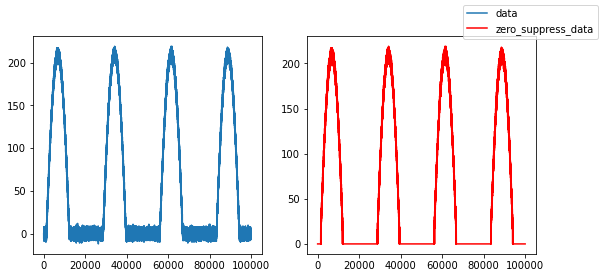

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)
threshold=np.array(15).astype(np.int16)

@vectorize([float32(float32, float32)], target='parallel', fastmath=True)
def zero_suppress(data, threshold):
    if data<threshold:
        data=0
    return data

        
fig, ax=plt.subplots(ncols=2, figsize=(9,4))
ax[0].plot(data, label='data')
ax[1].plot(zero_suppress(data,threshold),label='zero_suppress_data', color='r')
fig.legend()
plt.show()

## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [5]:
X = np.random.rand(3,3)
Y = np.random.rand(3,3)

X,Y,X*Y, np.dot(X.T,Y)

def sigmoid_kernel(X,Y,a,c):
    K=np.arctan(np.dot(X.T,Y)*a+c)
    return K

K=sigmoid_kernel(X,Y,1,1)
K

array([[1.06115148, 0.91780384, 0.84218249],
       [1.07334727, 0.97423336, 0.96682308],
       [1.01674903, 0.86287648, 0.79347671]])

## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [6]:
import os
import numpy as np
import math as m
os.environ["NUMBA_ENABLE_CUDASIM"] = "1"
from numba import jit, njit, vectorize, cuda

@cuda.jit
def kernel_3D(io_array):
    x,y,z = cuda.grid(3)
    if x < io_array.shape[0] and y < io_array.shape[1] and z <io_array.shape[2]:
        io_array[x][y][z] = np.cos(io_array[x][y][z])

# Host code   
data = np.random.random((32,32,32))

# Configure the blocks
threadsperblock = (4,4,4) #ThreadsPerBlock must be a divisor of the data dimension: 1024/ 64 / 16 = 1
blockspergrid_x = int(m.ceil(data.shape[0] / threadsperblock[0]))
blockspergrid_y = int(m.ceil(data.shape[1] / threadsperblock[1]))
blockspergrid_z = int(m.ceil(data.shape[2] / threadsperblock[2]))
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)

kernel_3D[blockspergrid, threadsperblock](data)
print(data)

[[[0.96050079 0.68414203 0.90414015 ... 0.98206853 0.9678259  0.99995087]
  [0.56925366 0.65943017 0.68295315 ... 0.9983439  0.99980719 0.87181436]
  [0.69632102 0.89719876 0.91551202 ... 0.94170406 0.99939104 0.56939891]
  ...
  [0.98782821 0.75950739 0.84871311 ... 0.666823   0.54120498 0.9922562 ]
  [0.84538956 0.95040717 0.98380082 ... 0.96513847 0.56514578 0.68068072]
  [0.99341798 0.61828439 0.68307943 ... 0.6268538  0.98154114 0.77625315]]

 [[0.88442652 0.97282674 0.65639931 ... 0.58386439 0.5500403  0.95369738]
  [0.97849272 0.56141281 0.79241011 ... 0.95965682 0.76893512 0.99999984]
  [0.97220654 0.71904558 0.83482179 ... 0.96977297 0.70879791 0.7408169 ]
  ...
  [0.97670674 0.98957581 0.83567961 ... 0.91443968 0.99400216 0.91142478]
  [0.98797121 0.79361427 0.97591843 ... 0.75411204 0.98099045 0.98621361]
  [0.91632628 0.57738877 0.58460105 ... 0.92227276 0.98257815 0.81601362]]

 [[0.94244492 0.89225744 0.99347291 ... 0.61663087 0.99825866 0.95463004]
  [0.57665753 0.777986

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [7]:
from __future__ import division
from numba import cuda
import numpy
import math

# complete the code
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays
A = np.ceil(np.random.random((24,12))*100)
B = np.ceil(np.random.random((12,22))*100)
C = np.ones((24,22))

# Configure the blocks
threadsperblock = (4,2)
blockspergrid_x = int(m.ceil(C.shape[0] / threadsperblock[0]))
blockspergrid_y = int(m.ceil(C.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x,blockspergrid_y)

matmul[blockspergrid, threadsperblock](A,B,C)
print(C)


[[24070. 18821. 29250. 27025. 20905. 23536. 19991. 25648. 25505. 21114.
  19739. 24380. 18427. 22627. 18595. 19295. 24084. 16767. 18247. 22692.
  27160. 20079.]
 [22457. 21287. 27435. 13710. 15622. 22973. 26962. 18028. 26216. 22318.
  19644. 21039. 23443. 18225. 14745. 24886. 20763. 17936. 27102. 25557.
  18572. 21675.]
 [36640. 32188. 43062. 35042. 29526. 35490. 34352. 32912. 45505. 35516.
  28977. 33003. 31640. 31759. 26032. 35675. 38297. 26271. 32451. 38150.
  32565. 36072.]
 [39015. 32438. 41482. 37829. 29115. 32424. 35579. 31314. 43380. 34229.
  29007. 32234. 32715. 33252. 29257. 36767. 35244. 22475. 28769. 39160.
  33787. 30591.]
 [27390. 26908. 32388. 31370. 23752. 25726. 28576. 27284. 33704. 27368.
  23313. 27202. 26204. 24193. 23234. 30763. 31466. 18128. 26102. 28616.
  26787. 27095.]
 [40928. 30598. 45720. 31974. 33835. 33367. 35453. 33313. 40766. 38594.
  31742. 36725. 37091. 30899. 32601. 38956. 35041. 26846. 31555. 42239.
  32489. 36746.]
 [33285. 31572. 41254. 38888. 2843